In [16]:
import os
import time
import sklearn
import pickle
import pydot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras_radam import RAdam

from helpers import*

## Loading the dataset 

In [24]:
data = pd.read_csv('datasets/bank-additional.csv', sep=';')
df = build_spectrum (data,do_spectrum = True ,spect = 0.5)

Fraction of No :
0.5
Fraction of Yes :
0.5


TypeError: '(slice(None, None, None), 20)' is an invalid key

# Neural Network

In [61]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [63]:
def build_model():
    model = Sequential()
    model.add(Dense(10, input_dim=19, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def run_benchmark(data, N_spec = 30):
    list_optimzers = ['adam', 'sgd', RAdam()]
    spects = np.linspace(0.5,0.99,N_spec)
    
    sgd_acc = []
    adam_acc = []
    radam_acc = []
    
    sgd_loss = []
    adam_loss = []
    radam_loss = []
    
    sgd_f1 = []
    adam_f1 = []
    radam_f1 = []
    
    sgd_precision = []
    adam_precision = []
    radam_precision = []
    
    sgd_recall = []
    adam_recall = []
    radam_recall = []
    
    for spect in spects:
        one_hot_enc = build_spectrum (data,do_spectrum = True ,spect = spect)
        X = one_hot_enc.drop(columns=['y'])
        y = one_hot_enc['y']
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
        x_train_keras, y_train_keras = build_keras (x_train,y_train)
        model = build_model()
        for l in list_optimzers:
            model.compile(loss='binary_crossentropy', optimizer=l, metrics=['acc',f1_m,precision_m, recall_m])
            model.fit(np.array(x_train_keras), np.array(y_train_keras), epochs=10, batch_size=128, shuffle=True, verbose=0)
            loss, accuracy, f1_score, precision, recall = model.evaluate(np.array(x_test), np.array(y_test),verbose = 0)
            
            if l == 'adam':
                adam_acc.append(accuracy)
                adam_loss.append(loss)
                adam_f1.append(f1_score)
                adam_precision.append(precision)
                adam_recall.append(recall)
                
            elif l == 'sgd':
                sgd_acc.append(accuracy)
                sgd_loss.append(loss)
                sgd_f1.append(f1_score)
                sgd_precision.append(precision)
                sgd_recall.append(recall)
            else:
                radam_acc.append(accuracy)
                radam_loss.append(loss)
                radam_f1.append(f1_score)
                radam_precision.append(precision)
                radam_recall.append(recall)
    return spects, sgd_acc, sgd_loss, sgd_f1, sgd_precision, sgd_recall, adam_acc,adam_loss, adam_f1, adam_precision, 
adam_recall, radam_acc,radam_loss, radam_f1, radam_precision, radam_recall

In [64]:
spects, sgd_acc, sgd_loss, sgd_f1, sgd_precision, sgd_recall, adam_acc,adam_loss, adam_f1, adam_precision, adam_recall, radam_acc,radam_loss, radam_f1, radam_precision, radam_recall = run_benchmark(data, N_spec=100)

Fraction of No :
0.5
Fraction of Yes :
0.5
Fraction of No :
0.5044345898004434
Fraction of Yes :
0.4955654101995565
Fraction of No :
0.5099778270509978
Fraction of Yes :
0.49002217294900224
Fraction of No :
0.5144124168514412
Fraction of Yes :
0.48558758314855877
Fraction of No :
0.5199556541019955
Fraction of Yes :
0.48004434589800443
Fraction of No :
0.524390243902439
Fraction of Yes :
0.47560975609756095
Fraction of No :
0.5299334811529933
Fraction of Yes :
0.4700665188470067
Fraction of No :
0.5343680709534369
Fraction of Yes :
0.4656319290465632
Fraction of No :
0.5399113082039911
Fraction of Yes :
0.46008869179600886
Fraction of No :
0.5443458980044346
Fraction of Yes :
0.4556541019955654
Fraction of No :
0.549889135254989
Fraction of Yes :
0.4501108647450111
Fraction of No :
0.5543237250554324
Fraction of Yes :
0.44567627494456763
Fraction of No :
0.5598669623059866
Fraction of Yes :
0.4401330376940133
Fraction of No :
0.5643015521064302
Fraction of Yes :
0.4356984478935698
Frac

# Results


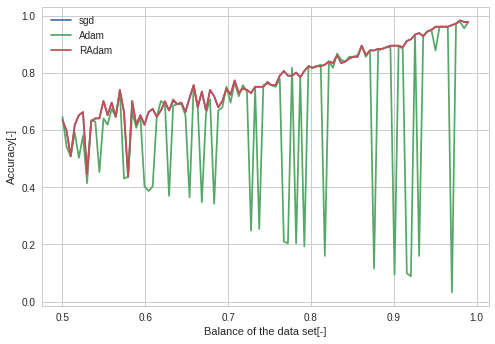

In [65]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_acc, label='sgd')
plt.plot(spects, adam_acc, label='Adam')
plt.plot(spects, radam_acc, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Accuracy[-]')
plt.legend(loc='upper left')
plt.savefig('figures/accuracy-spect.png')

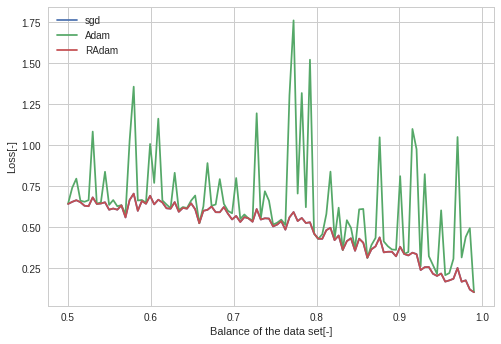

In [66]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_loss, label='sgd')
plt.plot(spects, adam_loss, label='Adam')
plt.plot(spects, radam_loss, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Loss[-]')
plt.legend(loc='upper left')
plt.savefig('figures/loss-spect.png')

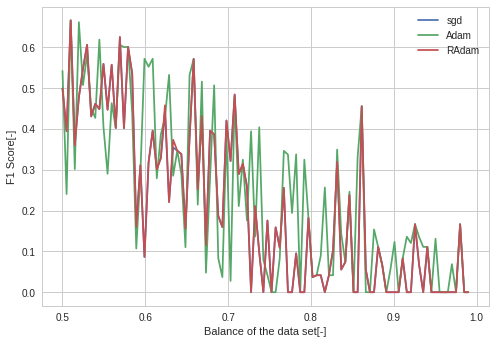

In [72]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_f1, label='sgd')
plt.plot(spects, adam_f1, label='Adam')
plt.plot(spects, radam_f1, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('F1 Score[-]')
plt.legend(loc='upper right')
plt.savefig('figures/f1-spect.png')

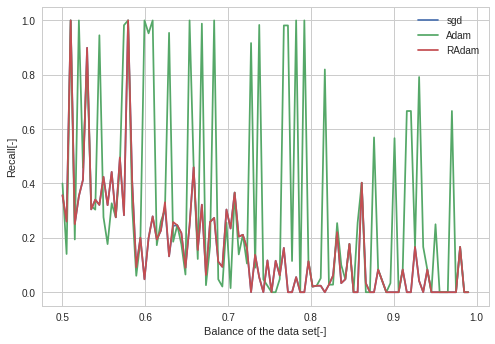

In [71]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_recall, label='sgd')
plt.plot(spects, adam_recall, label='Adam')
plt.plot(spects, radam_recall, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Recall[-]')
plt.legend(loc='upper right')
plt.savefig('figures/recall-spect.png')

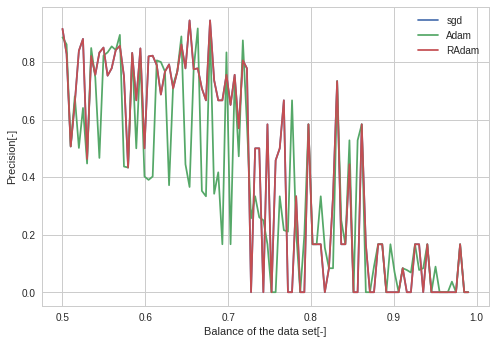

In [70]:
plt.style.use('seaborn-whitegrid')
plt.plot(spects, sgd_precision, label='sgd')
plt.plot(spects, adam_precision, label='Adam')
plt.plot(spects, radam_precision, label='RAdam')
plt.xlabel('Balance of the data set[-]')
plt.ylabel('Precision[-]')
plt.legend(loc='upper right')
plt.savefig('figures/precision-spect.png')